In [1]:
import os
import numpy as np
import pandas as pd
from pickle import dump, load

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
SEED = 42
np.random.seed(SEED)
# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

In [5]:
LABEL_COLUMN = 'price'

In [6]:
# Load the dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    y = df[LABEL_COLUMN].values
    x = df.drop(columns=[LABEL_COLUMN])
    return x, y

In [12]:
dataset_date = '20200802'
work_dir = os.path.join(os.path.dirname(os.getcwd()), 'data', dataset_date)

In [13]:
file_path = os.path.join(work_dir, 'diamonds.csv')
X, y = load_data(file_path)

In [14]:
# Split train/validation/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

print("Training data shape: {}".format(X_train.shape))

Training data shape: (218596, 29)


In [39]:
X_train.culet.unique()

array(['None', 'Very Small', 'Pointed', 'Medium', 'Small',
       'Slightly Large'], dtype=object)

In [40]:
# Diamond fluorescence itself is a debated topic, see https://www.leibish.com/diamond-fluorescence-article-245
# [TODO] Explore how different pair of color + fluorescence may result in different price
# Also use ordinal encoding now for Fluorescence, the ordinal may be a wrong assumption
# Now we just simplify based on UV light intensity
def map_fluorescence(x):
    if x == 'None':
        return 'None'
    elif 'Faint' in x:
        return 'Faint'
    elif 'Medium' in x:
        return 'Medium'
    elif 'Very Strong' in x:
        return 'Very Strong'
    elif 'Strong' in x:
        return 'Strong'
    else:
        raise ValueError("Not recognized value: {}".format(x))
    
fluorescence = ['Very Strong', 'Strong', 'Medium', 'Faint', 'None']
# ranking: the bigger the better
ranking = {
    'clarity': ['I2', 'I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF', 'FL'],
    'color': ['K', 'J', 'I', 'H', 'G', 'F', 'E', 'D'],
    'cut': ['Good', 'Very Good', 'Ideal', 'Astor Ideal'], # https://www.bluenile.com/education/diamonds/cut
    'culet': ['Slightly Large', 'Medium', 'Small', 'Very Small', 'Pointed', 'None'],
    'polish': ['Good', 'Very Good', 'Excellent'],
    'symmetry': ['Good', 'Very Good', 'Excellent'],
}

In [41]:
# Prepare Input
scaler_path = os.path.join(work_dir, 'scaler.pkl')

def prepare_input(df, y, train=False):
    """
        Input:
            x: pandas dataframe
        Output:
            x_num: (numpy array) numerical input features
            colnames: (list) column names
    """
    # split measurements
    measurements = df['measurements'].str.replace(' mm', '').str.split(' x ', expand=True)
    measurements = measurements.apply(pd.to_numeric)
    measurements.columns = ['length', 'width', 'height']
    df = df.join(measurements)
    
    # ordinal encoding (can't use pd.Categorical, in case missing certain categories)
    for key, value in ranking.items():
        value_map = {k: v for v, k in enumerate(value)}
        df['ord_{}'.format(key)] = df[key].map(value_map)
    
    # add categorical features 
    # onehot encoding Fluorescence (no straightforward ordering)
    df['fluorescence'] = df['fluorescence'].map(map_fluorescence) # reduce fluorescence options
    enc = OneHotEncoder(categories=[fluorescence], sparse=False)
    x_fluors = enc.fit_transform(df['fluorescence'].values.reshape(-1, 1))
    
    x_visual = df['hasVisualization'].astype(int).values.reshape(-1, 1)
    
    # select columns used in model
    cols_num = ['carat', 'depth', 'lxwRatio', 'table', 'sellingIndex', 'length', 'width', 'height']
    cols_ord = ['ord_{}'.format(key) for key in ranking.keys()]
    
    # polynomials (degree 2) for numerical+ordinal turn out to be useful
    poly_features = PolynomialFeatures(degree=2, include_bias=False)
    x_poly = poly_features.fit_transform(df[cols_num + cols_ord].values)
    
    # apply MinMax scale to only numerical+ordinal features
    if train:
        scaler = MinMaxScaler()
        scaler.fit(x_poly)
        # save scalar
        dump(scaler, open(scaler_path, 'wb'))
    else:
        scaler = load(open(scaler_path, 'rb'))
    
    # transform x
    x_minmax = scaler.transform(x_poly)
    print(x_minmax.shape)
    
    x = np.hstack((x_minmax, x_fluors, x_visual))
    print("X shape: ", x.shape)
    x = x.astype("float32")
    y = y.astype("float32")
    
    return x, y

In [42]:
X_train_scaled, y_train_scaled = prepare_input(X_train, y_train, train=True)
X_test_scaled, y_test_scaled = prepare_input(X_test, y_test, train=False)

(218596, 119)
X shape:  (218596, 125)
(54649, 119)
X shape:  (54649, 125)


In [43]:
m, n = X_train_scaled.shape
print("Training data shape after transformation: {}".format(X_train_scaled.shape))

Training data shape after transformation: (218596, 125)


In [44]:
# Initial loss benchmark - if we always predict the average price of the training set, what is the mse
y_train_fake = np.ones(len(y_train_scaled)) * np.mean(y_train_scaled)

print("Baseline mean_squared_error: {}".format(mean_squared_error(y_train_fake, y_train_scaled)))
print("Baseline mean_absolute_error: {}".format(mean_absolute_error(y_train_fake, y_train_scaled)))
print("Baseline r2: {}".format(r2_score(y_train_fake, y_train_scaled)))

Baseline mean_squared_error: 204122142.109803
Baseline mean_absolute_error: 4950.644626455418
Baseline r2: 0.0


In [ ]:
""" Best model with input 20200721 - 10k to 30k
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=256, activation="relu", input_shape=(n,)),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.Dense(1, activation="linear")
])

model.summary()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=opt, loss='mse', metrics=[keras.metrics.RootMeanSquaredError(), 'mae'])
#model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.RootMeanSquaredError(), 'mae'])

# checkpoint
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(patience=50),
    tf.keras.callbacks.ModelCheckpoint(os.path.join(work_dir, "dropout_weights.best.hdf5"), 
                                       monitor='val_mae', verbose=1, save_best_only=True, mode='min'),
    tf.keras.callbacks.TensorBoard(log_dir=os.path.join(work_dir, 'logs'))
]
"""

In [50]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=256, activation="relu", input_shape=(n,)),
    #tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.Dense(1, activation="linear")
])

model.summary()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=opt, loss='mse', metrics=[keras.metrics.RootMeanSquaredError(), 'mae'])
#model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.RootMeanSquaredError(), 'mae'])

# checkpoint
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(patience=50),
    tf.keras.callbacks.ModelCheckpoint(os.path.join(work_dir, "weights.best.hdf5"), 
                                       monitor='val_mae', verbose=1, save_best_only=True, mode='min'),
    tf.keras.callbacks.TensorBoard(log_dir=os.path.join(work_dir, 'logs'))
]

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               32256     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 73,473
Trainable params: 73,473
Non-trainable params: 0
_________________________________________________________________


In [51]:
history = model.fit(X_train_scaled, y_train_scaled, epochs=200, batch_size=256, validation_split=0.2, verbose=2, callbacks=callbacks_list)

Train on 174876 samples, validate on 43720 samples
Epoch 1/200

Epoch 00001: val_mae improved from inf to 659.27496, saving model to /Users/ruitao/WorkDocs/Code/diamonds/notebooks/data/20200802/dropout_weights.best.hdf5
174876/174876 - 7s - loss: 41508354.5108 - root_mean_squared_error: 6442.6963 - mae: 1544.8899 - val_loss: 11655028.2096 - val_root_mean_squared_error: 3413.9463 - val_mae: 659.2750
Epoch 2/200

Epoch 00002: val_mae did not improve from 659.27496
174876/174876 - 6s - loss: 7760067.9179 - root_mean_squared_error: 2785.6895 - mae: 717.2371 - val_loss: 34073232.9460 - val_root_mean_squared_error: 5837.2280 - val_mae: 1423.8921
Epoch 3/200

Epoch 00003: val_mae did not improve from 659.27496
174876/174876 - 6s - loss: 27035063.8925 - root_mean_squared_error: 5199.5264 - mae: 1195.0991 - val_loss: 21488657.7496 - val_root_mean_squared_error: 4635.5859 - val_mae: 1046.3062
Epoch 4/200

Epoch 00004: val_mae did not improve from 659.27496
174876/174876 - 6s - loss: 21827060.499

Epoch 32/200

Epoch 00032: val_mae did not improve from 549.70337
174876/174876 - 7s - loss: 15036534.8113 - root_mean_squared_error: 3877.6963 - mae: 818.3046 - val_loss: 6303652.6489 - val_root_mean_squared_error: 2510.7078 - val_mae: 639.6554
Epoch 33/200

Epoch 00033: val_mae did not improve from 549.70337
174876/174876 - 8s - loss: 9015584.7708 - root_mean_squared_error: 3002.5969 - mae: 725.4571 - val_loss: 6840257.7160 - val_root_mean_squared_error: 2615.3887 - val_mae: 661.6353
Epoch 34/200

Epoch 00034: val_mae did not improve from 549.70337
174876/174876 - 9s - loss: 12846648.1204 - root_mean_squared_error: 3584.2234 - mae: 787.7217 - val_loss: 10464823.7752 - val_root_mean_squared_error: 3234.9380 - val_mae: 820.0032
Epoch 35/200

Epoch 00035: val_mae did not improve from 549.70337
174876/174876 - 7s - loss: 8263464.1602 - root_mean_squared_error: 2874.6235 - mae: 713.8890 - val_loss: 9037542.6110 - val_root_mean_squared_error: 3006.2505 - val_mae: 616.5275
Epoch 36/200

Epo

Epoch 66/200

Epoch 00066: val_mae did not improve from 549.70337
174876/174876 - 7s - loss: 7115924.6455 - root_mean_squared_error: 2667.5693 - mae: 692.7960 - val_loss: 5360066.7609 - val_root_mean_squared_error: 2315.1816 - val_mae: 585.0856
Epoch 67/200

Epoch 00067: val_mae did not improve from 549.70337
174876/174876 - 6s - loss: 5819006.4687 - root_mean_squared_error: 2412.2612 - mae: 662.8568 - val_loss: 9309850.8311 - val_root_mean_squared_error: 3051.2048 - val_mae: 932.9374
Epoch 68/200

Epoch 00068: val_mae did not improve from 549.70337
174876/174876 - 6s - loss: 9767171.5785 - root_mean_squared_error: 3125.2480 - mae: 748.8715 - val_loss: 5411790.5923 - val_root_mean_squared_error: 2326.3257 - val_mae: 619.7242
Epoch 69/200

Epoch 00069: val_mae did not improve from 549.70337
174876/174876 - 6s - loss: 7704378.7759 - root_mean_squared_error: 2775.6775 - mae: 687.1957 - val_loss: 5488954.9075 - val_root_mean_squared_error: 2342.8516 - val_mae: 587.0368
Epoch 70/200

Epoch 

Epoch 98/200

Epoch 00098: val_mae did not improve from 520.33063
174876/174876 - 8s - loss: 4594932.6181 - root_mean_squared_error: 2143.5801 - mae: 587.6899 - val_loss: 6046022.2731 - val_root_mean_squared_error: 2458.8662 - val_mae: 557.6355
Epoch 99/200

Epoch 00099: val_mae did not improve from 520.33063
174876/174876 - 8s - loss: 2942642.7841 - root_mean_squared_error: 1715.4131 - mae: 534.3222 - val_loss: 4413438.9274 - val_root_mean_squared_error: 2100.8186 - val_mae: 530.4551
Epoch 100/200

Epoch 00100: val_mae improved from 520.33063 to 504.70038, saving model to /Users/ruitao/WorkDocs/Code/diamonds/notebooks/data/20200802/dropout_weights.best.hdf5
174876/174876 - 8s - loss: 3479382.3989 - root_mean_squared_error: 1865.3101 - mae: 560.2119 - val_loss: 4846549.4080 - val_root_mean_squared_error: 2201.4880 - val_mae: 504.7004
Epoch 101/200

Epoch 00101: val_mae did not improve from 504.70038
174876/174876 - 9s - loss: 4447115.9550 - root_mean_squared_error: 2108.8184 - mae: 560


Epoch 00129: val_mae did not improve from 479.61810
174876/174876 - 11s - loss: 3035573.3752 - root_mean_squared_error: 1742.2896 - mae: 524.2371 - val_loss: 4821946.0027 - val_root_mean_squared_error: 2195.8931 - val_mae: 505.3332
Epoch 130/200

Epoch 00130: val_mae did not improve from 479.61810
174876/174876 - 6s - loss: 4206567.6794 - root_mean_squared_error: 2050.9924 - mae: 541.2856 - val_loss: 4460407.1598 - val_root_mean_squared_error: 2111.9678 - val_mae: 493.8521
Epoch 131/200

Epoch 00131: val_mae did not improve from 479.61810
174876/174876 - 6s - loss: 3542523.7783 - root_mean_squared_error: 1882.1591 - mae: 520.4064 - val_loss: 4854051.7651 - val_root_mean_squared_error: 2203.1914 - val_mae: 587.2037
Epoch 132/200

Epoch 00132: val_mae did not improve from 479.61810
174876/174876 - 7s - loss: 2915047.4920 - root_mean_squared_error: 1707.3508 - mae: 510.8476 - val_loss: 4470567.7476 - val_root_mean_squared_error: 2114.3716 - val_mae: 535.0859
Epoch 133/200

Epoch 00133: v

Epoch 161/200

Epoch 00161: val_mae did not improve from 459.80914
174876/174876 - 7s - loss: 2887313.1564 - root_mean_squared_error: 1699.2094 - mae: 490.3813 - val_loss: 4630694.8429 - val_root_mean_squared_error: 2151.9048 - val_mae: 460.3343
Epoch 162/200

Epoch 00162: val_mae did not improve from 459.80914
174876/174876 - 6s - loss: 2739608.1945 - root_mean_squared_error: 1655.1758 - mae: 483.9217 - val_loss: 5012136.6314 - val_root_mean_squared_error: 2238.7803 - val_mae: 464.6278
Epoch 163/200

Epoch 00163: val_mae did not improve from 459.80914
174876/174876 - 6s - loss: 2643408.2275 - root_mean_squared_error: 1625.8560 - mae: 478.2909 - val_loss: 4488951.9210 - val_root_mean_squared_error: 2118.7148 - val_mae: 469.9276
Epoch 164/200

Epoch 00164: val_mae did not improve from 459.80914
174876/174876 - 6s - loss: 2984885.6874 - root_mean_squared_error: 1727.6820 - mae: 490.1136 - val_loss: 4204976.0903 - val_root_mean_squared_error: 2050.6038 - val_mae: 474.4883
Epoch 165/200

E

Epoch 193/200

Epoch 00193: val_mae did not improve from 444.52972
174876/174876 - 10s - loss: 2440531.2868 - root_mean_squared_error: 1562.2198 - mae: 456.0363 - val_loss: 4218017.6788 - val_root_mean_squared_error: 2053.7812 - val_mae: 453.8579
Epoch 194/200

Epoch 00194: val_mae did not improve from 444.52972
174876/174876 - 7s - loss: 2402298.0597 - root_mean_squared_error: 1549.9346 - mae: 459.2290 - val_loss: 4745235.5784 - val_root_mean_squared_error: 2178.3562 - val_mae: 445.6597
Epoch 195/200

Epoch 00195: val_mae did not improve from 444.52972
174876/174876 - 7s - loss: 3152323.9822 - root_mean_squared_error: 1775.4785 - mae: 467.4412 - val_loss: 4213404.3824 - val_root_mean_squared_error: 2052.6582 - val_mae: 461.8209
Epoch 196/200

Epoch 00196: val_mae improved from 444.52972 to 439.25690, saving model to /Users/ruitao/WorkDocs/Code/diamonds/notebooks/data/20200802/dropout_weights.best.hdf5
174876/174876 - 11s - loss: 2563354.9547 - root_mean_squared_error: 1601.0476 - mae:

dict_keys(['loss', 'root_mean_squared_error', 'mae', 'val_loss', 'val_root_mean_squared_error', 'val_mae'])


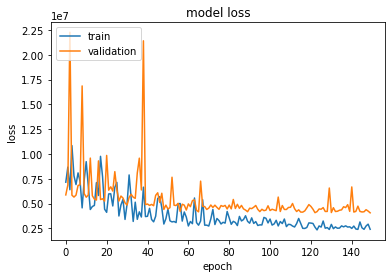

In [54]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'][50:])
plt.plot(history.history['val_loss'][50:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [55]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(os.path.join(work_dir, 'my_model.h5'))

In [56]:
# Test Set performance
nn_scores = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(nn_scores)

[3888378.7426805613, 1971.8972, 436.3301]


In [57]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model(os.path.join(work_dir, 'my_model.h5'))
new_model.load_weights(os.path.join(work_dir, "weights.best.hdf5"))
# Show the model architecture
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               32256     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 73,473
Trainable params: 73,473
Non-trainable params: 0
_________________________________________________________________


In [58]:
new_model.evaluate(X_test_scaled, y_test_scaled, verbose=0)

[4165578.6179779135, 2040.9752, 430.72968]

A Pure Polynomial Model

In [60]:
def print_cv_score(model, x, y, cv=5, scoring='neg_mean_squared_error'):
    scores = cross_val_score(model, x, y, scoring=scoring, cv=cv)
    if scoring == 'neg_mean_squared_error':
        scores = np.sqrt(-scores)
    elif scoring == 'neg_mean_absolute_error':
        scores = -scores
    print("CV Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    return scores

lr = LinearRegression()
lr_poly2_rmse_scores = print_cv_score(lr, X_train_scaled, y_train_scaled)
lr_poly2_mae_scores = print_cv_score(lr, X_train_scaled, y_train_scaled, scoring='neg_mean_absolute_error')
lr_poly2_r2_scores = print_cv_score(lr, X_train_scaled, y_train_scaled, scoring='r2')

CV Score: 3982.88 (+/- 1796.01)
CV Score: 1140.31 (+/- 43.80)
CV Score: 0.92 (+/- 0.05)
